In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv

In [3]:
for file_name in os.listdir('Data/'):
    if fnmatch.fnmatch(file_name, '*.dat'):
        print(file_name)

ZLP_200 keV_2ms_008.dat
ZLP_200 keV_2ms_009.dat
01.dat
ZLP_200 keV_2ms_007.dat
ZLP_200 keV_2ms_006.dat
ZLP_200 keV_2ms_010.dat
ZLP_200 keV_2ms_004.dat
ZLP_200 keV_2ms_005.dat
ZLP_200 keV_2ms_002.dat
ZLP_200 keV_2ms_003.dat


TypeError: column specifications must be a list or tuple, input was a 'str'

error: unpack requires a buffer of 4 bytes

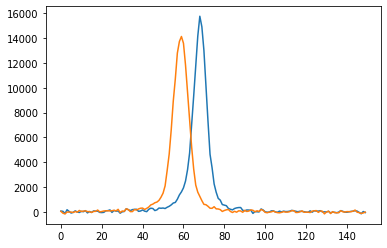

In [99]:
import struct

for file_name in os.listdir('Data/'):
    if fnmatch.fnmatch(file_name, '*.dat'):
        file = file_name
        with open('Data/'+file, 'rb') as f:
            n = 1000000
            datavector=[]
            count = 0
            byte = f.read(4) # same as size = 4 in R
            while count < n and byte != b"":
                datavector.append(struct.unpack('f',byte))
                count += 1
                byte = f.read(4)
        plt.plot(datavector[150:300])
        
with open('Data/ZLP_200 keV_2ms_004.dat', 'rb') as f:
    n = 1000000
    datavector=[]
    count = 0
    byte = f.read(4)
    while count < n and byte != b"":
        bye = f.read(4)
        datavector.append(struct.unpack('f',byte))
        count += 1
        byte = f.read(4)


len(datavector)

In [48]:
binary_file = open('Data/ZLP_200 keV_2ms_008.dat', "rb")
num=list(binary_file.read())
size(num)
binary_file.close()

In [58]:
with open("Data/ZLP_200 keV_2ms_005.dat","rb") as binary_file1:
    # Read the whole file at once
    data1 = list(binary_file1.read())
    print(data1)

[108, 221, 2, 67, 122, 252, 87, 67, 238, 54, 210, 193, 136, 253, 9, 195, 156, 40, 90, 66, 138, 253, 168, 66, 51, 166, 134, 194, 2, 140, 189, 193, 254, 181, 14, 194, 65, 209, 133, 65, 128, 186, 56, 191, 131, 104, 154, 193, 80, 210, 93, 66, 124, 0, 25, 194, 69, 154, 122, 193, 112, 168, 74, 66, 55, 163, 162, 194, 32, 109, 240, 193, 68, 53, 207, 63, 126, 3, 242, 66, 34, 143, 81, 66, 93, 255, 134, 193, 166, 36, 203, 194, 69, 182, 79, 193, 218, 5, 128, 65, 73, 18, 91, 66, 198, 75, 17, 192, 200, 174, 131, 194, 182, 254, 197, 65, 42, 182, 110, 66, 103, 120, 131, 66, 124, 242, 170, 66, 188, 11, 112, 66, 116, 17, 16, 66, 64, 252, 143, 65, 189, 120, 165, 66, 169, 100, 52, 66, 202, 41, 193, 193, 96, 98, 122, 193, 148, 105, 144, 63, 252, 73, 62, 193, 98, 65, 110, 194, 222, 26, 206, 66, 146, 145, 195, 65, 70, 15, 153, 194, 220, 114, 169, 194, 127, 149, 109, 194, 128, 197, 68, 190, 190, 216, 202, 66, 180, 202, 162, 65, 118, 35, 23, 194, 226, 55, 139, 194, 131, 14, 195, 194, 90, 168, 249, 193, 164, 18

In [74]:
with open("Data/ZLP_200 keV_2ms_005.dat", "rb") as binary_file:
    # Read the whole file at once
    data = binary_file.read()
    


In [55]:
with open("Data/ZLP_200 keV_2ms_006.dat", "rb") as binary_file:
    # Seek a specific position in the file and read N bytes
    couple_bytes = binary_file.read(4)
    print(couple_bytes)

b'5\xa9\xbaA'
